# Importações



 **Aluno:** Therlyson Ryan Souza Santos

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
from PIL import Image
import glob

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Carregando o dataset

In [ ]:
import numpy as np
from PIL import Image

def PreprocessData(target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of the desired size
    Please note the masks in this dataset have only one channel
    """
    m = len(path1)  # Use the length of path1 (assuming it's a list of image paths)
    i_h, i_w, i_c = target_shape_img
    m_h, m_w, m_c = target_shape_mask

    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)

    # Resize images and masks
    for index in range(m):
        single_img = Image.open(path1[index]).convert('RGB')
        single_img = single_img.resize((i_h, i_w))
        single_img = np.reshape(single_img, (i_h, i_w, i_c))
        single_img = single_img / 255.0
        X[index] = single_img

        single_mask = Image.open(path2[index])
        single_mask = single_mask.resize((m_h, m_w))

        single_mask = np.array(single_mask)

        single_mask[single_mask > 0.5] = 1
        single_mask[single_mask  <= 0] = 0

        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        # single_mask = single_mask - 1  # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

# Arquitetura da rede U-net

In [ ]:
def down_block(x, filtros, kernel_size=(3,3), padding = "same", strides=1):  #Encoder
  """
  #kernel = tamanho do filtro   #stride = incremento da convolução
  #padding="same": impede que os dados se percam quando faz a passagem
  """
  c = Conv2D(filtros, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = Conv2D(filtros, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  p = MaxPooling2D((2,2), (2,2))(c)   #reduz a imagem pela metade e aplica em c.

  return c,p

In [ ]:
def bottleneck(x, filtros, kernel_size=(3,3), padding = "same", strides=1):  # Bottleneck
  c = Conv2D(filtros, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = Conv2D(filtros, kernel_size, padding=padding, strides=strides, activation="relu")(c)

  return c

In [ ]:
def up_block(x, skip, filtros, kernel_size=(3,3),padding = "same", strides=1):  #DECODER
  up = UpSampling2D((2,2))(x)  #VOLTA A IMAGEM PARA 64 POR 64
  concat = tf.keras.layers.Concatenate()([up,skip])
  c = Conv2D(filtros,kernel_size,
             padding=padding,
             strides=strides,
             activation="relu")(concat)
  c = Conv2D(filtros,kernel_size,
             padding=padding,
             strides=strides,
             activation="relu")(c)

  return c

In [ ]:
def UNet(input_size=(128,128,3), n_filtros=32, n_classes= 1):  #Construção do modelo
  inputs = tf.keras.layers.Input(input_size)

  #Encoder   descendo a estrutura
  c1, p1 = down_block(inputs, n_filtros)
  c2, p2 = down_block(p1, n_filtros*2)
  c3, p3 = down_block(p2, n_filtros*4)
  c4, p4 = down_block(p3, n_filtros*8)

  #intermediario
  bn = bottleneck(p4, n_filtros*16)

  #Decoder   subindo a estrutura
  u1 = up_block(bn, c4, n_filtros*8)
  u2 = up_block(u1, c3, n_filtros*4)
  u3 = up_block(u2, c2, n_filtros*2)
  u4 = up_block(u3, c1, n_filtros)

  outputs = Conv2D(n_classes, 1, padding="same", activation="sigmoid")(u4)

  model = tf.keras.models.Model(inputs, outputs)
  return model


# Treinamento do modelo

## Carregando e visualizando o dataset

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

path = "/content/drive/MyDrive/DATASETS/archive.zip"
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pathMask = glob.glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
pathImages = [file.replace('_mask', '') for file in pathMask]

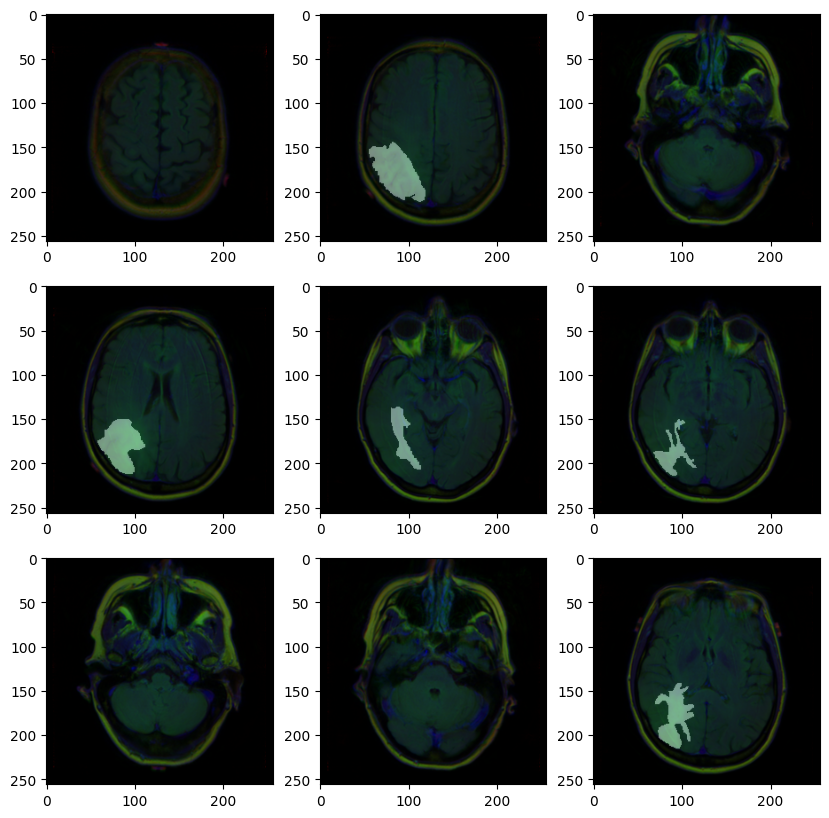

In [ ]:
import cv2
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=pathImages[i]
    msk_path=pathMask[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(data={"filename": pathImages, 'mask' : pathMask})
train_dataset, test_dataset = train_test_split(df,test_size = 0.1)
train_dataset, validation_dataset = train_test_split(train_dataset,test_size = 0.2)
print(train_dataset.values.shape)
print(validation_dataset.values.shape)
print(test_dataset.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [ ]:
df.head()

,filename,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...


In [ ]:
def display_image_mask(image_path, mask_path):
    plt.figure(figsize=(10, 5))

    # Lê a imagem e a máscara
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Converte a imagem e a máscara para RGB (OpenCV lê em BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Exibe a imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    # Exibe a máscara
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis('off')

    plt.show()

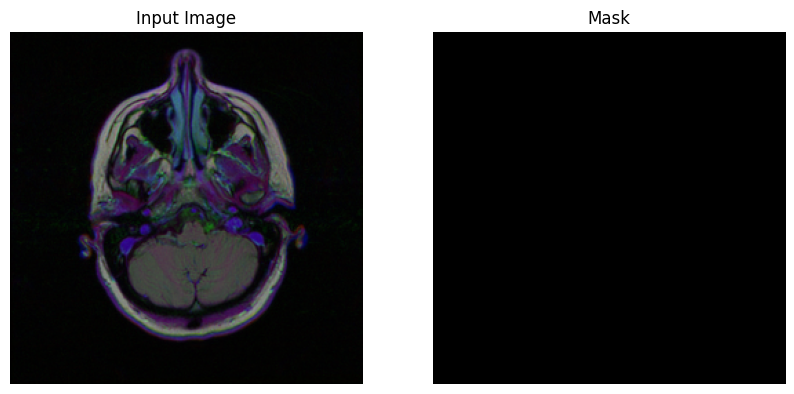

In [ ]:
sample_row = test_dataset.sample()
image_path = sample_row['filename'].values[0]
mask_path = sample_row['mask'].values[0]

display_image_mask(image_path, mask_path)

In [ ]:
# from sklearn.model_selection import train_test_split
# df_train, test_dataset = train_test_split(df, test_size=0.15)
# df_train, df_val = train_test_split(df_train, test_size=0.15)
# print(df_train.values.shape)
# print(df_val.values.shape)
# print(test_dataset.values.shape)

## Normalização de dados

In [ ]:
target_shape_img = [128,128,3]
target_shape_mask = [128,128,1]

X, y = PreprocessData(target_shape_img, target_shape_mask, pathImages, pathMask)

print("X Shape:", X.shape)
print("Y shape:", y.shape)

print(np.unique(y))

X Shape: (3929, 128, 128, 3)
Y shape: (3929, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

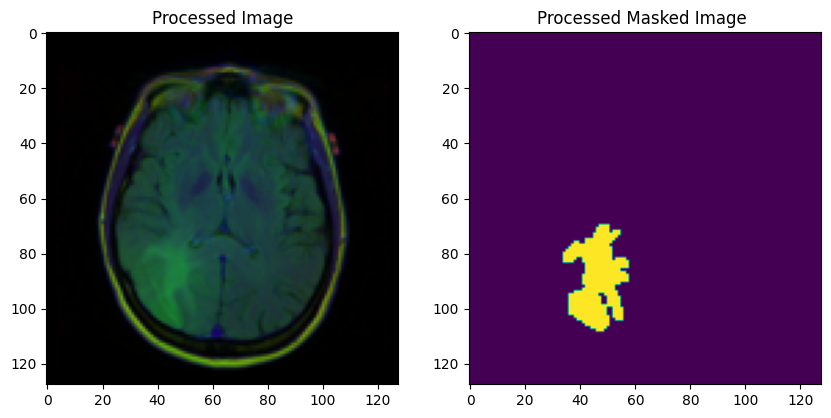

In [ ]:
# Visualize the output
image_index = 9
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

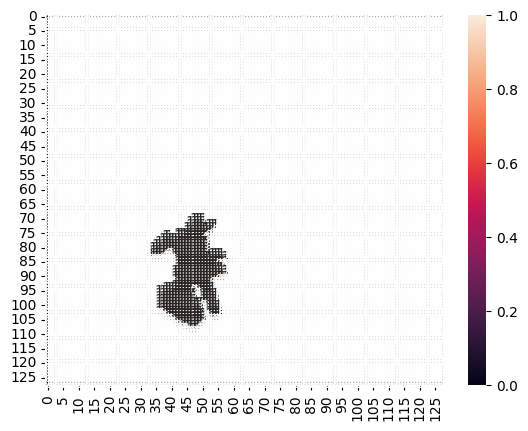

In [ ]:
import seaborn as sn    #visualização em pixel

df_cm = pd.DataFrame(y[image_index,:,:,0])
sn.heatmap(df_cm, annot=True)
plt.show()

## Divisão de treino e teste

In [ ]:
# 30% de dados como teste/conjunto válido
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3,shuffle=True)
print("Treinamento: \n",X_train.shape,y_train.shape)
print("Teste: \n",X_valid.shape,y_valid.shape)

Treinamento: 
 (2750, 128, 128, 3) (2750, 128, 128, 1)
Teste: 
 (1179, 128, 128, 3) (1179, 128, 128, 1)


In [ ]:
unet = UNet(input_size=(128,128,3), n_filtros=32, n_classes=1)

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Executando o modelo


In [ ]:
import keras
from keras import backend as K

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

unet.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
results = unet.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
86/86 [==============================] - 42s 252ms/step - loss: 0.0941 - mean_iou: 5.8570e-06 - val_loss: 0.0455 - val_mean_iou: 0.0000e+00
Epoch 2/30
86/86 [==============================] - 15s 174ms/step - loss: 0.0386 - mean_iou: 0.0407 - val_loss: 0.0390 - val_mean_iou: 0.1934
Epoch 3/30
86/86 [==============================] - 15s 177ms/step - loss: 0.0347 - mean_iou: 0.2235 - val_loss: 0.0394 - val_mean_iou: 0.2378
Epoch 4/30
86/86 [==============================] - 14s 166ms/step - loss: 0.0313 - mean_iou: 0.3143 - val_loss: 0.0336 - val_mean_iou: 0.3520
Epoch 5/30
86/86 [==============================] - 14s 168ms/step - loss: 0.0300 - mean_iou: 0.3721 - val_loss: 0.0575 - val_mean_iou: 0.0183
Epoch 6/30
86/86 [==============================] - 15s 170ms/step - loss: 0.0285 - mean_iou: 0.3961 - val_loss: 0.0306 - val_mean_iou: 0.4135
Epoch 7/30
86/86 [==============================] - 16s 183ms/step - loss: 0.0258 - mean_iou: 0.4433 - val_loss: 0.0261 - val_mean_iou

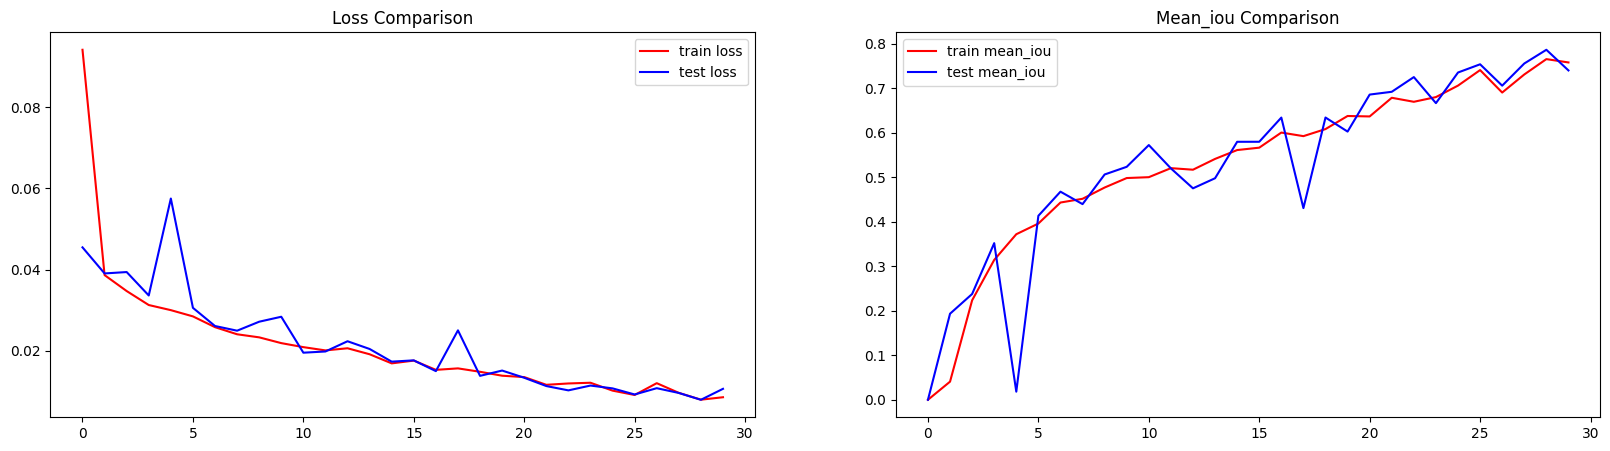

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'test loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["mean_iou"], color='r', label = 'train mean_iou')
axis[1].plot(results.history["val_mean_iou"], color='b', label = 'test mean_iou')
axis[1].set_title('Mean_iou Comparison')
axis[1].legend()

1/1 [==============================] - 0s 19ms/step


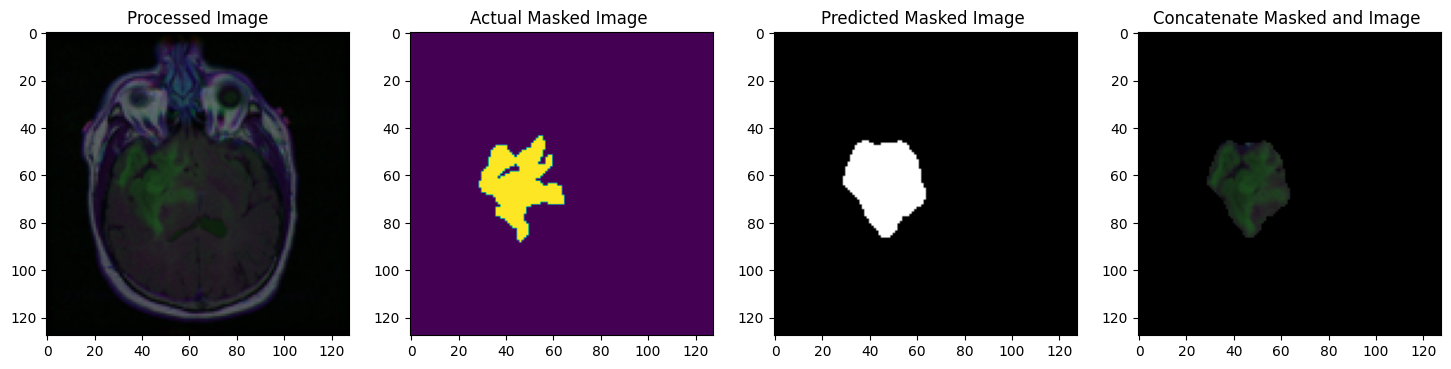

In [ ]:
unet.evaluate(X_valid, y_valid)

def VisualizeResults(index):
    raw = X_valid[index]
    pred = unet.predict(np.expand_dims(raw, 0))
    msk  = pred.squeeze()
    msk = np.stack((msk,)*3, axis=-1)
    msk[msk >= 0.5] = 1
    msk[msk < 0.5] = 0
    combined = raw* msk

    fig, arr = plt.subplots(1, 4, figsize=(18, 18))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(msk)
    arr[2].set_title('Predicted Masked Image ')
    arr[3].imshow(combined)
    arr[3].set_title('Concatenate Masked and Image ')

index = 3
VisualizeResults(index)